<a href="https://colab.research.google.com/github/microprediction/precise/blob/main/schur_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install --upgrade setuptools
!pip install --upgrade wheel
!pip install --upgrade ecos   # <--- Try conda install ecos if this fails
!pip install --upgrade osqp   # <-- Can be tricky on some systems see https://github.com/cvxpy/cvxpy/issues/1190#issuecomment-994613793
!pip install --upgrade pyportfolioopt # <--- Skip if you don't plan to use it
!pip install --upgrade riskparityportfolio
!pip install --upgrade scipy
!pip install --upgrade precise

In [ ]:
!pip install cvxpy

In [1]:
import numpy as np
import cvxpy as cp

# Define Q (covariance matrix) and b (expected returns)
Q = np.array([[0.04, 0.006, 0.004], [0.006, 0.09, 0.006], [0.004, 0.006, 0.025]])
b = np.array([0.10, 0.12, 0.15])

# Analytical approach
def analytical_port_b(Q, b):
    Q_inv = np.linalg.inv(Q)
    lambda_val = 2 / (b.T @ Q_inv @ b)
    w = (lambda_val / 2) * Q_inv @ b
    return w

def analytical_port_1(Q):
    """
        Special case where b is vector of ones
    """
    n = Q.shape[0]
    v = np.ones(shape=(n,))
    return analytical_port_b(Q=Q, b=v)


def analytical_port_b_alternative(Q, b):
    """
        Use a change of coordinate to reduce to special case analytical_port_1
    """
    Qb = Q / np.outer(b,b)
    w = analytical_port_1(Qb)
    return w / b


# Example covariance matrix Q and vector b
Q = np.array([[0.04, 0.006, 0.004], [0.006, 0.09, 0.006], [0.004, 0.006, 0.025]])
b = np.array([0.10, 0.12, 0.15])

# Calculate weights using both methods
w_original = analytical_port_b(Q, b)
w_alternative = analytical_port_b_alternative(Q, b)

# Comparing the results
comparison_result = np.allclose(w_original, w_alternative, atol=1e-6)
if not comparison_result:
    print({'w_original':w_original,
       'w_alternative':w_alternative})
else:
    print('Hoorah')


def cvxpy_port_1(Q):
    """
        Special case where b is vector of ones
    """
    n = Q.shape[0]
    v = np.ones(shape=(n,))
    return cvxpy_port_b(Q=Q, b=v)



# Using cvxpy for comparison
def cvxpy_port_b(Q, b):
    n = Q.shape[0]
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, Q))
    constraints = [cp.sum(cp.multiply(w, b)) == 1]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return w.value

# Calculate weights using both methods
w_analytical = analytical_port_b(Q, b)
w_cvxpy = cvxpy_port_b(Q, b)

# Output the results and comparison
print("Analytical weights:", w_analytical)
print("CVXPY weights:", w_cvxpy)
print("Are the weights close?", np.allclose(w_analytical, w_cvxpy, atol=1e-6))

Hoorah
Analytical weights: [1.64284911 0.7614118  4.96230449]
CVXPY weights: [1.64284911 0.7614118  4.96230449]
Are the weights close? True


In [2]:
from precise.skaters.portfoliostatic.allstaticport import LONG_PORT
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from scipy.optimize import minimize

def estimate_quadratic_form_with_b(X, y):
    """
      Robustly estimate the expression (X^T y)^T (X^T X)^{-1} (X^T y) for given X and y.

      Parameters:
      - X: The matrix X.
      - y: The vector y.

      Returns:
      - The estimate of the expression.
    """
    # Compute b = X^T y
    b = X.T @ y

    # Compute Q = X^T X and its pseudo-inverse
    Q = X.T @ X
    Q_pinv = np.linalg.pinv(Q)

    # Compute and return the expression
    return b.T @ Q_pinv @ b


def port_regression_special(X, y, port):
    b =  X.T @ y
    Q =  X.T @ X
    if False:
      w = analytical_port_b(Q = Q, b=b)
    else:
      Qb = Q / (b @ b.T )
      w = port(Q) / b

    inv_nu = b.T @ np.linalg.pinv(Q) @ b
    beta = inv_nu * w
    return beta


def squared_error(lambda_, X, y, beta):
    """
    Calculate the squared error of the predictions with rescaled coefficients.
    """
    predictions = X @ (beta * lambda_)
    return np.sum((y - predictions) ** 2)


def find_optimal_lambda(X, y, beta):
    """
    Find the lambda that minimizes the squared error.
    """
    result = minimize(squared_error, x0=1.0, args=(X, y, beta))
    return result.x[0]


def port_regression(X,y, port, line_search=True):
    """
        OLS with scaling
    """
    X = X - np.mean(X, axis=0)
    std_devs = np.std(X, axis=0)
    std_devs[std_devs ==0] = 1
    X_scaled = X / std_devs

    beta_scaled = port_regression_special(X_scaled, y, port)

    beta = beta_scaled / std_devs

    if line_search:
       lambda_ = find_optimal_lambda(X_scaled, y, beta)
       beta = beta*lambda_

    return beta


def schur_regression(X,y):
    from precise.skaters.portfoliostatic.schurport import schur_unit_weak_s5_g100_port as s5
    return port_regression(X=X, y=y, port=s5)

def hrp_regression(X,y):
    from precise.skaters.portfoliostatic.hrpport import hrp_diag_diag_s5_long_port as h5
    return port_regression(X=X, y=y, port=h5)

def unit_port_pure(cov):
    return unitary_from_pre(np.linalg.inv(cov))

def unitary_from_pre(pre, phi=1.0):
    """ Signed min var portfolio summing to unity """
    # No optimization required
    n_dim = np.shape(pre)[1]
    wones = np.ones(shape=(n_dim, 1))
    from precise.skaters.locationutil.vectorfunctions import normalize
    w = normalize(np.squeeze(np.matmul(pre, wones)))
    sum_w = np.sum(w)
    if abs(sum_w-1)<1e-4:
        return np.array(w)
    else:
        print('Warning. Unitary portfolio failed.')
        return np.ones_like(w)/n_dim


def unit_regression(X,y):
    from precise.skaters.portfoliostatic.unitport import unit_port as up
    return port_regression_special(X=X, y=y, port=unit_port_pure)

import numpy as np

def scaled_regression(X,y):
    """
        OLS with scaling
    """
    X = X - np.mean(X, axis=0)
    std_devs = np.std(X, axis=0)
    std_devs[std_devs ==0] = 1
    X_scaled = X / std_devs
    beta_scaled = np.linalg.inv(X_scaled.T @ X_scaled) @ X_scaled.T @ y
    beta = beta_scaled / std_devs
    return beta

def test_scaled_regression():
    np.random.seed(0)
    X = np.random.randn(1000, 50)
    beta_true = np.array([1, 1, 1, 1, -1, 2, 2, 2, 2, 2]*5)
    y = X @ beta_true + np.random.randn(1000) * 0.5

    beta_custom = scaled_regression(X, y)
    beta_port = unit_regression(X, y)
    beta_hrp = hrp_regression(X,y)
    beta_schur = schur_regression(X,y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    model = LinearRegression(fit_intercept=False)
    model.fit(X_scaled, y)
    beta_sklearn = model.coef_ / scaler.scale_

    print("Custom implementation coefficients:", beta_custom)
    print("Port regression special coefficients:", beta_port)
    print("scikit-learn implementation coefficients:", beta_sklearn)
    print("Schur coefficients:", beta_schur)
    print('HRP coefficients:', beta_hrp)

    assert np.allclose(beta_custom, beta_sklearn, atol=1e-6), "The coefficients do not match closely enough."

    print("Test passed: The coefficients match closely between the custom implementation, port_regression_special, and scikit-learn's.")

test_scaled_regression()

Custom implementation coefficients: [ 1.00394404  1.00101244  0.98604402  0.99411553 -1.00779756  2.02206025
  1.99890455  2.01712081  1.99839708  2.02811794  0.98476052  1.01679591
  1.02976976  0.9915431  -0.96640799  1.99517801  1.99337859  2.01313501
  1.987767    2.0096497   0.98144382  1.00055326  1.00462235  0.98135243
 -0.97076441  1.99569078  1.97222357  2.02214309  2.01916881  2.0046913
  0.98070427  0.99183814  1.01016456  0.98930339 -1.00618418  1.99341331
  2.02156476  2.0054314   2.00081339  1.97143532  1.00290907  0.9917496
  0.99776909  0.97276666 -1.00624605  2.0166339   2.01275879  1.98304077
  2.00271798  2.0072813 ]
Port regression special coefficients: [ 4.46338197 19.54082224  2.43600167  0.97207529 -1.95083178  2.50991688
  0.72087277  0.9779235   2.12461801  1.80481131  2.28203133  1.78702586
  1.76189318  3.14697399 -2.72344694  0.93155611  0.82338879  1.67662111
  1.826796    1.2175634   2.01600797  2.03934161  1.94067613  0.88730001
 -2.77285038  2.85275244  

## Testing out of sample

<ipython-input-3-1c317147392b>:50: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=cov_matrix, size=n_samples)


MSE values sorted from lowest to highest:
Ridge                 MSE: 69.6753566554431
NNLS Regression.      MSE: 81.81922397054139
Lasso                 MSE: 100.12337380064562
Zero prediction       MSE: 113.50160175440578
Schur Regression.     MSE: 130.02694734922122
HRP Regression.       MSE: 134.14715903964054
Sklearn lin reg       MSE: 398.2385706677219
Port Regression.      MSE: 2376.887906890707
Custom Implementation MSE: 111077.8474894728
The coefficients do not match closely enough between sklearn and custom regression
Test passed: The coefficients match closely between the custom implementation and scikit-learn's.


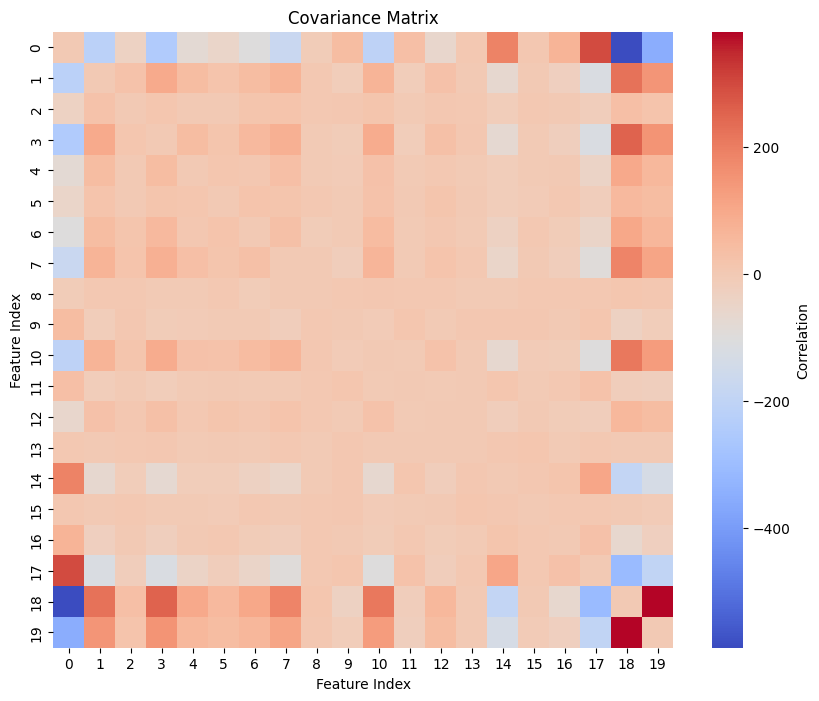

In [3]:

import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.optimize import nnls
from sklearn.datasets import make_spd_matrix

def nnls_regression(X, y):
    beta_nnls, rnorm = nnls(X, y)
    return beta_nnls

def test_scaled_regression():
    np.random.seed(0)
    # Generate correlated X
    n_samples =  4000
    n_features = 20
    n_informative = 20
    beta_true = np.concatenate([
    np.random.normal(loc=0.0, scale=0.1, size=n_features-n_informative),
    np.random.normal(loc=1.5, scale=0.1, size=n_informative)
    ])

    # Create a covariance matrix
    n_samples = 400

    # Create a structured covariance matrix
    standard_deviations = np.linspace(0.1, 0.5, n_features)  # Standard deviations increasing from 0.1 to 2

    # Initialize the covariance matrix
    cov_matrix = np.zeros((n_features, n_features))

    # Fill the covariance matrix with values that decrease with distance
    n_blocks = 1  # Define the number of blocks

    # Ensure each block has an equal number of features for simplicity
    block_size = n_features // n_blocks
    standard_deviations = np.linspace(0.1, 0.1, n_features)

    # Initialize the covariance matrix
    cov_matrix = make_spd_matrix(n_features)
    cov_matrix = (cov_matrix + cov_matrix.T) / 2


    # Generate X data with hierarchical covariance structure
    X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=cov_matrix, size=n_samples)

    # Ensure the matrix is symmetric and positive-definite
    np.fill_diagonal(cov_matrix, standard_deviations**2)
    cov_matrix = (cov_matrix + cov_matrix.T) / 2
    X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=cov_matrix, size=n_samples)


    # Generate y with some noise
    y = X @ beta_true + np.random.randn(n_samples) * 5.

    # Split the data into training and testing sets
    train_proportion = 0.05
    split_idx = int(n_samples * train_proportion)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Fit models on the training set
    beta_custom = scaled_regression(X_train, y_train)
    beta_port = unit_regression(X_train, y_train)
    beta_hrp = hrp_regression(X_train, y_train)
    beta_schur = schur_regression(X_train, y_train)
    beta_nnls = nnls_regression(X_train, y_train)

    # Regularized regressions
    ridge_model = Ridge(alpha=1.0, fit_intercept=False)
    ridge_model.fit(X_train, y_train)
    beta_ridge = ridge_model.coef_

    lasso_model = Lasso(alpha=0.1, fit_intercept=False)
    lasso_model.fit(X_train, y_train)
    beta_lasso = lasso_model.coef_

    # Scale X for comparison with scikit-learn
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train_scaled, y_train)
    beta_sklearn = model.coef_ / scaler.scale_

    # Evaluate model performance on the test set
    y_pred_sklearn = X_test @ beta_sklearn
    y_pred_custom = X_test @ beta_custom
    y_pred_port = X_test @ beta_port
    y_pred_hrp = X_test @ beta_hrp
    y_pred_schur = X_test @ beta_schur
    y_pred_nnls = X_test @ beta_nnls

    # Calculate and print out-of-sample mean squared error
    mse_zero = mean_squared_error(y_test,np.zeros_like(y_test))
    mse_custom = mean_squared_error(y_test, y_pred_custom)
    mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
    mse_port = mean_squared_error(y_test, y_pred_port)
    mse_hrp = mean_squared_error(y_test, y_pred_hrp)
    mse_schur = mean_squared_error(y_test, y_pred_schur)
    mse_nnls = mean_squared_error(y_test, y_pred_nnls)
    mse_ridge = mean_squared_error(y_test, X_test @ beta_ridge)
    mse_lasso = mean_squared_error(y_test, X_test @ beta_lasso)


    mse_dict = {
    'Sklearn lin reg      ': mse_sklearn,
    'Zero prediction      ': mse_zero,
    'Ridge                ': mse_ridge,
    'Lasso                ': mse_lasso,
    'Custom Implementation': mse_custom,
    'Port Regression.     ': mse_port,
    'HRP Regression.      ': mse_hrp,
    'Schur Regression.    ': mse_schur,
    'NNLS Regression.     ': mse_nnls
    }

    # Sort the MSE values from lowest to highest
    sorted_mse = sorted(mse_dict.items(), key=lambda item: item[1])

    # Print the sorted MSE values
    print("MSE values sorted from lowest to highest:")
    for name, mse in sorted_mse:
        print(f"{name} MSE: {mse}")


    # Add assertions or comparisons as needed, for example:
    if not np.allclose(beta_custom, beta_sklearn, atol=1e-4):
         print("The coefficients do not match closely enough between sklearn and custom regression")

    print("Test passed: The coefficients match closely between the custom implementation and scikit-learn's.")


    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(10, 8))
    corr_matrix = np.zeros_like(cov_matrix)

    # Convert covariance matrix to correlation matrix
    for i in range(n_features):
        for j in range(n_features):
            corr_matrix[i, j] = cov_matrix[i, j] / (np.sqrt(cov_matrix[i, i] * cov_matrix[j, j]))

    sns.heatmap(corr_matrix, cmap='coolwarm', cbar_kws={'label': 'Correlation'})
    plt.title('Covariance Matrix')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Index')
    plt.show()


# Call the test function
test_scaled_regression()


In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_spd_matrix
from scipy.optimize import nnls
# Import the precise package or specific functions if necessary
# from precise import <list_of_port_functions>

def nnls_regression(X, y):
    beta_nnls, rnorm = nnls(X, y)
    return beta_nnls


def test_scaled_regression():
    np.random.seed(0)
    # Setup and data generation as specified in your script

    # Generate correlated X
    n_samples =  50
    train_proportion = 0.5
    n_features = 20
    n_informative = 5
    beta_true = np.concatenate([
    np.random.normal(loc=0.0, scale=0.1, size=n_features-n_informative),
    np.random.normal(loc=1.0, scale=0.5, size=n_informative)
    ])


    # Create a structured covariance matrix
    standard_deviations = np.linspace(0.1, 0.5, n_features)  # Standard deviations increasing from 0.1 to 2

    # Initialize the covariance matrix
    cov_matrix = np.zeros((n_features, n_features))

    # Initialize the covariance matrix
    cov_matrix = make_spd_matrix(n_features)
    cov_matrix = (cov_matrix + cov_matrix.T) / 2


    # Generate X data with hierarchical covariance structure
    X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=cov_matrix, size=n_samples)


    # Generate y with some noise
    y = X @ beta_true + np.random.randn(n_samples) * 5.

    # Split the data into training and testing sets

    split_idx = int(n_samples * train_proportion)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]



    # Placeholder for storing MSE results
    mse_results = {}

    # Fit models on the training set
    beta_custom = scaled_regression(X_train, y_train)
    beta_port = unit_regression(X_train, y_train)
    beta_hrp = hrp_regression(X_train, y_train)
    beta_schur = schur_regression(X_train, y_train)
    beta_nnls = nnls_regression(X_train, y_train)

    # Regularized regressions
    ridge_model = Ridge(alpha=1.0, fit_intercept=False)
    ridge_model.fit(X_train, y_train)
    beta_ridge = ridge_model.coef_

    lasso_model = Lasso(alpha=0.1, fit_intercept=False)
    lasso_model.fit(X_train, y_train)
    beta_lasso = lasso_model.coef_

    # Scale X for comparison with scikit-learn
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train_scaled, y_train)
    beta_sklearn = model.coef_ / scaler.scale_

    # Evaluate model performance on the test set
    y_pred_sklearn = X_test @ beta_sklearn
    y_pred_custom = X_test @ beta_custom
    y_pred_port = X_test @ beta_port
    y_pred_hrp = X_test @ beta_hrp
    y_pred_schur = X_test @ beta_schur
    y_pred_nnls = X_test @ beta_nnls

    # Calculate and print out-of-sample mean squared error
    mse_zero = mean_squared_error(y_test,np.zeros_like(y_test))
    mse_custom = mean_squared_error(y_test, y_pred_custom)
    mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
    mse_port = mean_squared_error(y_test, y_pred_port)
    mse_hrp = mean_squared_error(y_test, y_pred_hrp)
    mse_schur = mean_squared_error(y_test, y_pred_schur)
    mse_nnls = mean_squared_error(y_test, y_pred_nnls)
    mse_ridge = mean_squared_error(y_test, X_test @ beta_ridge)
    mse_lasso = mean_squared_error(y_test, X_test @ beta_lasso)


    mse_results = {
    'Sklearn lin reg      ': mse_sklearn,
    'Zero prediction      ': mse_zero,
    'Ridge                ': mse_ridge,
    'Lasso                ': mse_lasso,
    'Custom Implementation': mse_custom,
    'Port Regression.     ': mse_port,
    'HRP Regression.      ': mse_hrp,
    'Schur Regression.    ': mse_schur,
    'NNLS Regression.     ': mse_nnls
    }


    # Get the list of all port methods from precise
    from precise.skaters.portfoliostatic.allstaticport import PORT as port_functions

    for k, port_function in enumerate(port_functions):
        print(port_function.__name__)
        # Run regression with the current port function
        beta_port = port_regression(X_train, y_train, port_function)

        # Evaluate model performance on the test set
        y_pred_port = X_test @ beta_port
        mse_port = mean_squared_error(y_test, y_pred_port)

        # Store the MSE result
        mse_results[port_function.__name__] = mse_port

        if (k % 20 ==1) or k==len(port_functions)-1:
          # Sort and display MSE results from all regressions
          sorted_mse = sorted(mse_results.items(), key=lambda item: item[1])
          print(' ')
          print(' ')
          print("MSE values sorted from lowest to highest:")
          for name, mse in sorted_mse:
              print(f"{name} MSE: {mse}")

# Call the test function
test_scaled_regression()

print('Done')

ppo_sharpe_long_port
ppo_vol_long_port
 
 
MSE values sorted from lowest to highest:
HRP Regression.       MSE: 20.529032445089566
ppo_sharpe_long_port MSE: 21.027663141648112
ppo_vol_long_port MSE: 21.027663141648112
Schur Regression.     MSE: 21.468808596555878
Zero prediction       MSE: 22.084882881358794
Ridge                 MSE: 23.08802200551705
Lasso                 MSE: 26.324642233612632
NNLS Regression.      MSE: 28.993185344984393
Custom Implementation MSE: 84.5315967717654
Sklearn lin reg       MSE: 84.53159677176784
Port Regression.      MSE: 2910.8321083339983
ppo_quad_long_port
weak_long_port
weak_h125_long_port
weak_h150_long_port
weak_h200_long_port
weak_h400_long_port
diag_long_port
hrp_weak_weak_s5_long_port
hrp_diag_diag_s5_long_port
hrp_diag_weak_s5_long_port
hrp_weak_diag_s5_long_port
schur_diag_diag_s5_g100_long_port
schur_weak_weak_s5_g100_long_port
schur_diag_diag_s5_g050_long_port
schur_weak_weak_s5_g050_long_port
schur_weak_diag_s5_g100_long_port
schur_weak_